 This is the best model for Llama 7B

In [1]:
import json
import re
import pandas as pd
from datasets import Dataset        
from fuzzywuzzy import fuzz


class Evaluator():

    def __init__(self,  data: Dataset, offset:bool, output_cleaner) -> None:
        self.offset = offset
        self.data = data
        self.cleaner = output_cleaner
        pass


    def _drop_duplicates(self, model_response: list) -> str:
        """
        Drop the duplicates from a list. This is useful when the model output contains the same entity multiple times.

        Args:
        model_response (str): the model response with no duplicates
        """
        # print('DROPPING DUPLICATES: ', model_response)
        try :
            return list({v['entity']:v for v in model_response}.values())
        except Exception as error:
            model_response = self._remove_space_from_dict_keys(model_response)
            # print('ERROR: ', model_response)
            return list({v['entity']:v for v in model_response}.values())
        

    def _change_apexes(self, model_output: str) -> str:
        """
        Extract the text between the curl brackets of the model output, and change the apexes from double single \'.

        Args:
        model_output (str): the example from the dataset

        """
        text_between_curl_brackets = re.findall(r'\{(.+?)\}', model_output)
        cleaned_output = '['
        for el in text_between_curl_brackets:
            key_part, value_part = el.split(': ', 1)
            first_occurrence = value_part.find('"')
            last_occurrence = value_part.rfind('"')
            tmp = '{' + key_part + ': "' + value_part[first_occurrence+1:last_occurrence].replace('"', "'") + '"' + '}'
            cleaned_output += tmp + ', '
        cleaned_output = cleaned_output[:-2] + ']'
        return cleaned_output
    
    def _assess_model_output(self, model_response: str) -> (bool, str):
        """
        Check if the model output is in the right format. If not, return False.
        
        Args:
        model_output (str): the postprocessed model output after beeing passed to _postprocess_model_output()

        return:
        bool: True if the format is correct, False otherwise
        str: the model output in the adjusted format
        """
        good_format = True
        # if self.cleaner.verbose: print('prima sostituz:  ', model_response)
        model_response = model_response.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(": \'", ": \"")
        model_response = re.sub(r'(?<=[a-zA-Z])"(?=[a-zA-Z])', "'", model_response)
        # if self.cleaner.verbose: print('dopo sostituz: ', model_response)
        try :
            out = json.loads(model_response)
            if isinstance(out, dict):
                model_response = '[' + model_response + ']'
        except Exception as error:
            if hasattr(error, 'msg'):
                if error.msg.startswith('Expecting property name enclosed in double quotes'):
                    model_response = model_response.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(": \'", ": \"")
                    try:
                        out = json.loads(model_response)
                        if isinstance(out, dict):
                            model_response = '[' + model_response + ']'
                            good_format = True
                    except Exception as error2:
                        if isinstance(error2, json.decoder.JSONDecodeError):
                            if error2.msg == "Expecting ',' delimiter":
                                model_response = self._change_apexes(model_response)
                                good_format = True
            else:
                #print('MODEL RESPNSE: ', model_response)
                good_format = False
        if not good_format:
            model_response = re.findall(r'\[\{(.+?)\}\]', model_response)
            if len(model_response) != 0:
                model_response = '[{' + model_response[0] + '}]'
                good_format = True
                try :
                    json.loads(model_response)
                except Exception as error:
                    good_format = False
            else:
                good_format = False
        return good_format, model_response

    def _parse_json(self, model_response: str, drop_duplicates: bool = True) -> dict:
        """
        Parse the model output to extract the entities and their offsets if present.
        
        Args:
        model_response (str): the model response 
        drop_duplicates (bool): if True, drop the duplicates in the model response
        """
        # print('MODEL RESPONSE 1: ', model_response)
        model_response = model_response.replace("\n", " ")

        good_format, model_response = self._assess_model_output(model_response)

        # print('MODEL RESPONSE 2: ', model_response)        
        # print('MODEL RESPONSE 3: ', model_response)
        if model_response == []:
            model_response = '[{"entity":""}]'
        if self.offset and good_format:
            output = json.loads(model_response)
            if drop_duplicates:
                output = self._drop_duplicates(output)
            entities = [entity["entity"] for entity in output]
            offsets = [entity["offset"] for entity in output]
            return {"entities": entities, "offsets": offsets}
        if (not self.offset) and good_format:

            # print('MODEL RESPONSE 4: ', model_response)
            # print('ORA STO PARSANDO: ', model_response)
            output = json.loads(model_response)
            # print('OUTPUT: ', type(output))
            if drop_duplicates:
                output = self._drop_duplicates(output)
            entities = [entity["entity"] for entity in output]
            # print('ENTITIES: ', entities)
            return {"entities": entities}
        if not good_format:
            return {"entities": []}
    
    def _count_common_words(self, string1: str, string2: str) -> int:
        """
        Count the number of common words between two entities without considering repetition.

        Args:
        string1 (str): an entity in the model response
        string2 (str): an entity in the ground truth

        return:
        int: the number of common words
        """
        model_words = set(string1.lower().split())
        ground_truth_words = set(string2.lower().split())
        common_words = model_words.intersection(ground_truth_words)
        return len(common_words)
        
    def _entity_similar_to_ground_truth_entity_LowerUppercase(self, entity_in_model_response: str, entity_in_ground_truth: str) -> (bool, str):
        """
        Check if two entities are similar, i.e. if the difference is just a fact of being upper or lower case.

        Args:
        entity_in_model_response (str): an entity in the model response
        entity_in_ground_truth (str): an entity in the ground truth
        threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely different, 100 is the same.

        return:
        bool: True if the entities are similar, False otherwise
        str: the entity in the ground truth if the entities are similar, the entity in the model response otherwise

        """
        FP_words = 0
        FN_words = 0
        TP_words = 0
        if entity_in_model_response.lower() == entity_in_ground_truth.lower():
            # print('SIMILI CASE: ', entity_in_model_response, ' e ', entity_in_ground_truth)
            TP_words = len(entity_in_ground_truth.split())
            return True, entity_in_ground_truth, FP_words, FN_words, TP_words
        return False, entity_in_model_response, FP_words, FN_words, TP_words
    
    def _entity_similar_to_ground_truth_entity_StopWords(self, entity_in_model_response: str, entity_in_ground_truth: str) -> (bool, str):
        """
        Check if two entities are similar, i.e. if the difference is just a stop words (e.g., "the" or "a"). Everything is performend in lower case.
        This is useful when the model output is not exactly the same as the ground truth.

        Args:
        entity_in_model_response (str): an entity in the model response
        entity_in_ground_truth (str): an entity in the ground truth
        threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely different, 100 is the same.

        return:
        bool: True if the entities are similar, False otherwise
        str: the entity in the ground truth if the entities are similar, the entity in the model response otherwise
        """
        def __preprocess_string__(string):
            # Remove common articles and noise words
            noise_words = ["a", "an", "the", "of"]
            words = string.split()
            filtered_words = [word for word in words if word.lower() not in noise_words]
            return ' '.join(filtered_words)
        
        FP_words = 0
        FN_words = 0
        TP_words = 0
        normalized_string = __preprocess_string__(entity_in_model_response)
        normalized_entity_ground_truth = __preprocess_string__(entity_in_ground_truth)
        if normalized_string == normalized_entity_ground_truth:
            n_words_ground_truth = len(entity_in_ground_truth.split())
            n_words_model_response = len(entity_in_model_response.split())
            FP_words = max(0, n_words_model_response - n_words_ground_truth)
            FN_words = max(0, n_words_ground_truth - n_words_model_response)
            TP_words = self._count_common_words(entity_in_model_response, entity_in_ground_truth)
            #print('SIMILI NORMALIZED: ', entity_in_model_response, ' e ', entity_in_ground_truth, ' -> FP_words:', FP_words,' FN_words:', FN_words,'TP_words:', TP_words)
            return True, entity_in_ground_truth, FP_words, FN_words, TP_words
        return False, entity_in_model_response, FP_words, FN_words, TP_words

    def _entity_similar_to_ground_truth_entity_Subset(self, entity_in_model_response: str, entity_in_ground_truth: str, ground_truth:list) -> (bool, str, int, int):
        """
        Check if two entities are similar in terms of being a subset of the one in list. E.g., entity='am happy' ground truth='I am happy'.
        This is useful when the model output is not exactly the same as the ground truth.

        Args:
        entity_in_model_response (str): an entity in the model response
        entity_in_ground_truth (str): an entity in the ground truth

        return:
        bool: True if the entities are similar, False otherwise
        str: the entity in the ground truth if the entities are similar, the entity in the model response otherwise
        FP_words: number of identified false positive words, i.e. number of words identified as entity that are not in the ground truth
        FN_words: number of identified false positive words, always 0 in this case
        TP_words: number of identified true positive words
        """
        FP_words = 0
        FN_words = 0
        TP_words = 0
        if entity_in_model_response.lower() != entity_in_ground_truth.lower():
            if entity_in_model_response.lower() in entity_in_ground_truth.lower():
                # words_not_in_gt_entity = entity_in_ground_truth.lower().replace(entity_in_model_response.lower(), '')
                # w_are_in_other_entity = any([words_not_in_gt_entity in gt_entity for gt_entity in ground_truth])
                # if w_are_in_other_entity:
                #     TP_words = self._count_common_words(entity_in_model_response, entity_in_ground_truth)
                # else:
                FN_words = entity_in_ground_truth.strip().count(" ") - entity_in_model_response.strip().count(" ")
                TP_words = self._count_common_words(entity_in_model_response, entity_in_ground_truth)
                # print('SIMILI Subset: ', entity_in_model_response, ' e ', entity_in_ground_truth, ' -> FP_words:', FP_words,' FN_words:', FN_words,'TP_words:', TP_words)
                return True, entity_in_ground_truth, FP_words, FN_words, TP_words
        return False, entity_in_model_response, FP_words, FN_words, TP_words

    def _entity_similar_to_ground_truth_entity_Superset(self, entity_in_model_response: str, entity_in_ground_truth: str) -> (bool, str, int, int):
        """
        Check if two entities are similar in terms of being a super of the one in list. E.g., entity='I am very happy' ground truth='I am happy'.
        This is useful when the model output is not exactly the same as the ground truth.

        Args:
        entity_in_model_response (str): an entity in the model response
        entity_in_ground_truth (str): an entity in the ground truth
        threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely different, 100 is the same.

        return:
        bool: True if the entities are similar, False otherwise
        str: the entity in the ground truth if the entities are similar, the entity in the model response otherwise
        FP_words: number of identified false positive words, i.e. number of words identified as entity that are not in the ground truth
        FN_words: number of identified false positive words, always 0 in this case
        """
        FP_words = 0
        FN_words = 0
        TP_words = 0
        if entity_in_model_response.lower() != entity_in_ground_truth.lower():
            if entity_in_ground_truth.lower() in entity_in_model_response.lower():
                FP_words = entity_in_model_response.strip().count(" ") - entity_in_ground_truth.strip().count(" ")
                TP_words = self._count_common_words(entity_in_model_response, entity_in_ground_truth)
                # print('SIMILI Superset: ', entity_in_model_response, ' e ', entity_in_ground_truth, ' -> FP_words:', FP_words,' FN_words:', FN_words,'TP_words:', TP_words)
                return True, entity_in_ground_truth, FP_words, FN_words, TP_words
        return False, entity_in_model_response, FP_words, FN_words, TP_words


    def _entity_similar_to_ground_truth_entity_Leveshtein(self, entity_in_model_response: str, entity_in_ground_truth: str, threshold: int) -> (bool, str):
        """
        Check if two entities are similar in terms of Leveshtein distance. This is useful when the model output is not exactly the same as the ground truth.

        Args:
        entity_in_model_response (str): an entity in the model response
        entity_in_ground_truth (str): an entity in the ground truth
        threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely different, 100 is the same.

        return:
        bool: True if the entities are similar, False otherwise
        str: the entity in the ground truth if the entities are similar, the entity in the model response otherwise
        """
        similarity = fuzz.ratio(entity_in_model_response.lower(), entity_in_ground_truth.lower())
        if similarity >= threshold:
            # print('SIMILI LEVESHTEIN: ', entity_in_model_response, ' e ', entity_in_ground_truth)
            return True, entity_in_ground_truth
        return False, entity_in_model_response
    

    def _entity_similar_to_ground_truth_entity(self, entity_in_model_response: str, entity_in_ground_truth: str, leveshtein_threshold: int, similarity_types:list=['case', 'stop_words', 'subset', 'superset', 'leveshtein'], ground_truth:list=[]) -> (bool, str):
        """
        Check if two entities are similar. This is useful when the model output is not exactly the same as the ground truth.

        Args:
        entity_in_model_response (str): an entity in the model response
        entity_in_ground_truth (str): an entity in the ground truth
        leveshtein_threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely different, 100 is the same.
        similarity_types (list): the list of similarity types to consider. The default value is ['case', 'stop_words', 'subset', 'superset', 'leveshtein']

        return:
        bool: True if the entities are similar, False otherwise
        str: the entity in the ground truth if the entities are similar, the entity in the model response otherwise
        """
        FP_words = 0
        FN_words = 0
        TP_words = 0

        if entity_in_model_response == entity_in_ground_truth:
            TP_words = len(entity_in_model_response.split())
            return True, entity_in_ground_truth, FP_words, FN_words, TP_words
        
        if 'case' in similarity_types:
            similar, entity_to_output, FP_words, FN_words, TP_words = self._entity_similar_to_ground_truth_entity_LowerUppercase(entity_in_model_response, entity_in_ground_truth)
            #print('SIMILI CASE: ', similar, entity_to_output, FP_words, FN_words, TP_words)
            if similar:
                return similar, entity_to_output, FP_words, FN_words, TP_words
        if 'stop_words' in similarity_types:
            similar, entity_to_output, FP_words, FN_words, TP_words = self._entity_similar_to_ground_truth_entity_StopWords(entity_in_model_response, entity_in_ground_truth)
            #print('SIMILI STOP WORDS: ', similar, entity_to_output, FP_words, FN_words, TP_words)
            if similar:
                return similar, entity_to_output, FP_words, FN_words, TP_words
        if 'subset' in similarity_types:
            similar, entity_to_output, FP_words, FN_words, TP_words = self._entity_similar_to_ground_truth_entity_Subset(entity_in_model_response, entity_in_ground_truth, entity_in_ground_truth)
            #print('SIMILI SUBSET: ', similar, entity_to_output, FP_words, FN_words, TP_words)
            if similar:
                return similar, entity_to_output, FP_words, FN_words, TP_words
        if 'superset' in similarity_types:
            similar, entity_to_output, FP_words, FN_words, TP_words = self._entity_similar_to_ground_truth_entity_Superset(entity_in_model_response, entity_in_ground_truth)  
            #print('SIMILI SUPERSET: ', similar, entity_to_output, FP_words, FN_words, TP_words)
            if similar:
                return similar, entity_to_output, FP_words, FN_words, TP_words
        if 'leveshtein' in similarity_types:
            similar, entity_to_output = self._entity_similar_to_ground_truth_entity_Leveshtein(entity_in_model_response, entity_in_ground_truth, leveshtein_threshold)
            #print('SIMILI LEVESTAIN: ', similar, entity_to_output)
            if similar:
                FP_words, FN_words, TP_words = 0, 0, 0 # non calcolo FP, FN, TP per leveshtein
                return similar, entity_to_output, FP_words, FN_words, TP_words

        return False, entity_in_model_response, FP_words, FN_words, TP_words
    

    # def _entity_similar_to_ground_truth_entity_deprecated(self, entity_in_model_response: str, entity_in_ground_truth: str, threshold: int) -> (bool, str):
    #     """
    #     Check if two entities are similar. This is useful when the model output is not exactly the same as the ground truth.

    #     Args:
    #     entity_in_model_response (str): an entity in the model response
    #     entity_in_ground_truth (str): an entity in the ground truth
    #     threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely different, 100 is the same.

    #     return:
    #     bool: True if the entities are similar, False otherwise
    #     str: the entity in the ground truth if the entities are similar, the entity in the model response otherwise
    #     """
    #     def __preprocess_string__(string):
    #         # Remove common articles and noise words
    #         noise_words = ["a", "an", "the", "of"]
    #         words = string.split()
    #         filtered_words = [word for word in words if word.lower() not in noise_words]
    #         return ' '.join(filtered_words)

    #     if entity_in_model_response == entity_in_ground_truth:
    #         return True, entity_in_ground_truth
        
    #     normalized_string = __preprocess_string__(entity_in_model_response)
    #     normalized_entity_ground_truth = __preprocess_string__(entity_in_ground_truth)
    #     if normalized_string == normalized_entity_ground_truth:
    #         print('SIMILI NORMALIZED 1: ', entity_in_model_response, ' e ', entity_in_ground_truth)
    #         return True, entity_in_ground_truth
        
    #     similarity = fuzz.ratio(entity_in_model_response.lower(), entity_in_ground_truth.lower())
    #     if similarity >= threshold:
    #         print('SIMILI LEVESTAIN 2: ', entity_in_model_response, ' e ', entity_in_ground_truth)
    #         return True, entity_in_ground_truth
    #     return False, entity_in_model_response
    
        
    def entity_in_ground_truth_list(self, entity_in_model_response: str, ground_truth: list, model_response_list: list, leveshtein_threshold: int, similarity_types:'list[str]') -> (str, int, int):
        """
        Check if an entity is in the ground truth

        Args:
        entity_in_model_response (str): an entity in the model response
        ground_truth (list): the ground truth
        model_response_list (list): the list off all entities already in the answer
        threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely different, 100 is the same.
        similarity_types: the list of similarity types to consider. Must contain elements in ['case', 'stop_words', 'subset', 'superset', 'leveshtein']

        return:
        bool: True if the entity is in the ground truth, False otherwise
        str: the entity in the ground truth if the entity is in the ground truth, the entity in the model response otherwise
        """
        strings = []
        FPs = []
        FNs = []
        TPs = []
        #print('\n ENTITY IN MODEL RESPONSE: ', entity_in_model_response)
        # if entity_in_model_response in ground_truth:
        #     print('TROVATO: ', entity_in_model_response)
        #     FPs.append(0)
        #     FNs.append(0)
        #     TPs.append(len(entity_in_model_response.split()))
        for entity_in_ground_truth in ground_truth:
            is_in, string, FP, FN, TP = self._entity_similar_to_ground_truth_entity(entity_in_model_response, entity_in_ground_truth, leveshtein_threshold, similarity_types, ground_truth)
            if is_in:
                strings.append(string)
                FPs.append(FP)
                FNs.append(FN)
                TPs.append(TP)
                continue
        #if entity_in_model_response in ground_truth and entity_in_model_response
        #print('STRINGS: ', strings)
        if len(strings) > 0:
            if entity_in_model_response in strings: # se ho estratto la stessa, ritorno se stessa
                TP = len(entity_in_model_response.split())
                #print('returning: ', entity_in_model_response, ' con TP: ', TP)
                return entity_in_model_response, 0, 0, TP
            else: #
                #print('sto analizzando: "', entity_in_model_response, '" e ho trovato: ', strings)

                #print('returning: ', entity_in_model_response, ' con TP: ', TP, ' FP: ', FP, ' FN: ', FN)
                return strings[-1], FPs[-1], FNs[-1], TPs[-1]
        else:
            FP = len(entity_in_model_response.split())
            FN = 0
            TP = 0
           
        #print('returning: ', entity_in_model_response, ' con TP: ', TP, ' FP: ', FP, ' FN: ', FN)
        return entity_in_model_response, FP, FN, TP
    


    def _extract_TP_FP_FN(self, model_response: str, ground_truth: str, similar_is_equal:bool=True, similar_is_equal_threshold: int=100, similarity_types:'list[str]'=['case', 'stop_words', 'subset', 'superset', 'leveshtein'], words_level:bool=True, already_parsed_inputs:bool=False) -> [int, int, int]:
        """
        Compute the F1 score, the precision and the recall between the model output and the ground truth

        Args:
        model_response (str): the model output as it is returned by the model
        ground_truth (str): the ground truth in json format.
        similar_is_equal (bool): if True, the function will consider similar entities as equal. The default value is False.
        similar_is_equal_threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely different, 100 is the same.
        words_level (bool): if True, the function will consider as base elements the words. If False, the function will consider as base elements the entity. 
        E.g., if True, the original sentence is "Yesterday morning I was so very happy and sad", the ground truth is ["yesterday morning", "so very happy"] the model output is ["morning", "happy and"], the function will consider FP=2 ("and"); TP=1 ("morning", "happy"); FN=2 ("Yesterday", "so"). 
        If False, the function will consider FP=1 ("happy and"); TP=0; FN=2 ("Yesterday morning", "so very happy").
        similarity_types: the list of similarity types to consider. Must contain elements in ['case', 'stop_words', 'subset', 'superset', 'leveshtein']

        """
        # print('MODEL RESPONSE: ', model_response)
        # print('GROUND TRUTH: ', ground_truth)
        if not already_parsed_inputs:
            # print('ORIGINAL model_response: ', model_response)
            model_response = self._parse_json(model_response)
            # print('GROUND TRUTH: ', ground_truth)
            ground_truth = self._parse_json(ground_truth.replace('\n', ''))
        model_response = model_response["entities"]
        ground_truth = ground_truth["entities"]
        
        
        # print('PARSED ORIGINAL model_response: ', model_response)
        # print('PARSED GROUND TRUTH: ', ground_truth)
        if not similar_is_equal:
            similarity_types = []

        if words_level:
            FP_sum = 0
            FN_sum = 0
            TP_sum = 0
            identified_entities_list = []
            for i, response_entity in enumerate(model_response):
                entity_identified, FP, FN, TP= self.entity_in_ground_truth_list(response_entity, ground_truth, model_response, similar_is_equal_threshold, similarity_types)
                FP_sum += FP
                FN_sum += FN
                TP_sum += TP
                identified_entities_list.append(entity_identified)
            #print('IDENTIFIED ENTITIES: ', identified_entities_list)
            #print('GROUND TRUTH: ', ground_truth)
            FN_entities = set(ground_truth).difference(set(identified_entities_list))
            FN_entities = [entity.split() for entity in FN_entities]
            FN_entities = [item for row in FN_entities for item in row]
            #print('FALSE NEGATIVES: ', FN_entities)
            FN_sum += len(FN_entities)
            #print('PARSED GROUND TRUTH: ', ground_truth, 'TP_sum:', TP_sum, 'FP_sum:', FP_sum, 'FN_sum:', FN_sum, '\n\n')
            return [TP_sum, FP_sum, FN_sum]
           
        elif not words_level:
            for i, response_entity in enumerate(model_response):
                model_response[i], _, _, _= self.entity_in_ground_truth_list(response_entity, ground_truth, model_response, similar_is_equal_threshold, similarity_types)
            #print('PARSED GROUND TRUTH: ', ground_truth)
            #print('NEW model_response to calculate TP, FP, FN: ', model_response, '\n\n')

            TP = len(set(model_response).intersection(set(ground_truth)))
            FP = len(set(model_response).difference(set(ground_truth)))
            FN = len(set(ground_truth).difference(set(model_response)))
            # F1 = 2 * TP / (2 * TP + FN + FP)
            return [TP, FP, FN]
    
    def generate_evaluation_table(self, similar_is_equal_threshold: int, words_level:bool, similarity_types:'list[str]', already_parsed_inputs:bool=False, add_TP_FP_TN_FN_to_data:bool=False) -> dict:
        """
        Generate the evaluation table for the model output and the ground truth.

        Args:
        similar_is_equal_threshold (int): the threshold to consider the entities similar by the Leveshtein distance. The default value is 80. 0 is completely
        different, 100 is the same. 
        words_level (bool): if True, the function will consider as base elements the words. If False, the function will consider as base elements the entity. 
        E.g., if True, the original sentence is "Yesterday morning I was so very happy and sad", the ground truth is ["yesterday morning", "so very happy"] the model output is ["morning", "happy and"], the function will consider FP=2 ("and"); TP=1 ("morning", "happy"); FN=2 ("Yesterday", "so"). 
        If False, the function will consider FP=1 ("happy and"); TP=0; FN=2 ("Yesterday morning", "so very happy").
        similarity_types: the list of similarity types to consider. Must contain elements in ['case', 'stop_words', 'subset', 'superset', 'leveshtein']

        return:
        dict: the evaluation table
        """
        self.evaluation_table = None
        metrics_list = []
        if not already_parsed_inputs:
            for i, res in enumerate(self.data['model_output']):
            #  if self.cleaner.verbose: print('res:', res)
                metrics_list.append(self._extract_TP_FP_FN(res, self.data['ground_truth'][i], True, similar_is_equal_threshold, similarity_types, words_level, already_parsed_inputs))
        else:
            for i, res in enumerate(self.data['model_output_parsed']):
                metrics_list.append(self._extract_TP_FP_FN(res, self.data['ground_truth_parsed'][i], True, similar_is_equal_threshold, similarity_types, words_level, already_parsed_inputs))
        metrics_dataframe = pd.DataFrame(metrics_list, columns=['TP', 'FP', 'FN'])
        summary = metrics_dataframe.sum()
        precision = summary['TP'] / (summary['TP'] + summary['FP'])
        recall = summary['TP'] / (summary['TP'] + summary['FN'])
        f1 = 2 * (precision * recall) / (precision + recall)
        self.evaluation_table = {'evaluation': metrics_dataframe, 'precision':precision, 'recall':recall, 'f1':f1}
        if add_TP_FP_TN_FN_to_data: self.add_TP_FP_TN_FN_to_data(already_parsed_inputs=already_parsed_inputs)

        return {'evaluation': metrics_dataframe, 'precision':precision, 'recall':recall, 'f1':f1}

    def add_TP_FP_TN_FN_to_data(self, already_parsed_inputs:bool=False):
        """
        Add the True Positives, False Positives, False Negatives, Precision, Recall and F1 score to the data. Precision, recall and f1 are approximated to avoid division by zero.
        """
        metrics_list = []
        if not already_parsed_inputs:
            for i, res in enumerate(self.data['model_output']):
                metrics_list.append(self._extract_TP_FP_FN(res, self.data['ground_truth'][i], True, 100, ['case', 'subset', 'superset'], already_parsed_inputs=already_parsed_inputs))
        else:
            for i, res in enumerate(self.data['model_output_parsed']):
                metrics_list.append(self._extract_TP_FP_FN(res, self.data['ground_truth_parsed'][i], True, 100, ['case', 'subset', 'superset'], already_parsed_inputs=already_parsed_inputs))
        if 'TP' in self.data.column_names:
            self.data = self.data.remove_columns(['TP', 'FP', 'FN', 'precision', 'recall', 'f1'])
        self.data = self.data.add_column('TP', [el[0] for el in metrics_list])
        self.data = self.data.add_column('FP', [el[1] for el in metrics_list])
        self.data = self.data.add_column('FN', [el[2] for el in metrics_list])
        self.data = self.data.add_column('precision', [el[0] / (el[0] + el[1] + 1e-16) for el in metrics_list])
        self.data = self.data.add_column('recall', [el[0] / (el[0] + el[2] + 1e-16) for el in metrics_list])
        def _f1(example):
            example['f1'] = 2 * (example['precision'] * example['recall']) / (example['precision'] + example['recall'] + 1e-16)
            return example
        self.data = self.data.map(lambda x: _f1(x))

/Users/pietroferrazzi/Desktop/dottorato/mistral_finetuning/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/pietroferrazzi/Desktop/dottorato/mistral_finetuning/.venv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
data_path = "data/llama/7B_NoQuant_FT/maxNewTokensFactor8_nShotsInference0_llama-2-7b-chat-hf_adapters_en.layer1_NoQuant_torch.bfloat16_16_32_0.01_2_0.0002.csv"
apadpetrs_checkpoint = "ferrazzipietro/llama-2-7b-chat-hf_adapters_en.layer1_NoQuant_torch.bfloat16_16_32_0.01_2_0.0002"

In [40]:
import json
import re
from typing import Tuple
from typing import List
from datasets import Dataset
import pandas as pd
from fuzzywuzzy import fuzz


class OutputAnalist():
    def __init__(self, data, verbose=False) -> None:
        self.verbose = verbose
        self.data = data
        self.counter_dict = {
            'perfect_output':0,
            'is_empty_list':0,
            'is_list_of_lists':0,
            'is_list_of_dicts':0,
            'is_list_of_lists_and_dict':0,
            'is_list_of_strings':0,
            'is_list_of_empty_dict':0,
            'is_list_with_one_empty_dict':0,
            'is_list_of_dicts_with_empty_lists':0,
            'is_list_of_dicts_with_one_key_multiple_values':0,
            'is_list_of_dicts_with_multiple_keys_included_entity':0,
            'is_list_of_dict_numeric_values':0,
            'is_list_of_dicts_none_values':0,
            'is_list_of_dicts_and_strings':0,
            'is_list_of_dicts_and_lists_of_strings':0,
            'is_list_of_dicts_with_value_list':0,
            'is_string':0,
            'is_list_of_strings_representing_dicts':0,
            'is_list_of_dicts_of_lists':0,
            'is_numeric':0,
            'are_entities_extracted_as_dict_keys_instead_of_values':0,
            'uknown':0
        }
  
    def _remove_space_from_dict_keys(self, model_ouput_list: list) -> list:
        """
        Remove the spaces from the keys of a dictionary. E.g., [{"entity ": "value"}] -> [{"entity": "value"}]

        Args:
        model_ouput_list (dict): the list of dictionaries to be cleaned

        return:
        list: the cleaned list of dicts
        """
        out = []
        for dict in model_ouput_list:
            # print('DICT: ', dict)
            out.append({k.replace(' ', ''): v for k, v in dict.items()})
        return out
    
    def _drop_duplicates(self, model_response: list) -> str:
        """
        Drop the duplicates from a list. This is useful when the model output contains the same entity multiple times.

        Args:
        model_response (str): the model response with no duplicates
        """
        # print('DROPPING DUPLICATES: ', model_response)
        try :
            return list({v['entity']:v for v in model_response}.values())
        except Exception as error:
            model_response = self._remove_space_from_dict_keys(model_response)
            # print('ERROR: ', model_response)
            return list({v['entity']:v for v in model_response}.values())
        
    def _assess_model_output(self, model_response: str) -> bool:
        """
        Check if the model output is in the right format. If not, return False.
        
        Args:
        model_output (str): the postprocessed model output after beeing passed to _postprocess_model_output()

        return:
        bool: True if the format is correct, False otherwise
        """
        good_format = True
        try :
            res = json.loads(model_response)
            # print( res)
        except:
            good_format = False
        return good_format

            
    def _remove_json_special_chars(self, string):
        """
        Remove the special characters from a string. This is useful when the model output contains special characters that are not allowed in the json format.
        """
        # print('sto pulendo: ', string)
        chars = ['\xa0', '\x80', '\x93', '\U00100000', '\r\n', '\U00100000I', '\\u001d', '\\"']
        for char in chars:
            string = string.replace(char, ' ')
        char_no_space = ['\xad']
        for char in char_no_space:
            string = string.replace(char, '')
        string = string.replace('\\u0010', '^')
        return string
    
    
    def _clean_ground_truth(self, example: dict) -> dict:
        ground_truth = example['ground_truth']
        # print('inner ground truth: ', ground_truth)
        ground_truth = self._remove_json_special_chars(ground_truth)
        ground_truth = ground_truth.replace('</s>', '').replace('<|im_e', '').replace('<|end_of_text|>', '').replace('<|endoftext|>', '')
        return({'ground_truth': ground_truth})

    def _clean_model_output(self, example: dict,  wrong_keys_to_entity:bool, latest_version:bool=True) -> dict:
        """
        Postprocess the model output to return a json like formatted string that can be used to compute the F1 score.

        Args:
        model_output (str): the model output as it is returned by the model. The processing of the output is done in the function
        wrong_keys_to_entity (bool): if True, the function also extracts the dictionaries with keys different from 'entity', converting the keys into 'entity'. If not, all keys that are not 'entity' are dropped

        return:
        dict: the model response

        """
       
        def is_empty_list(string:str)  -> bool:
            if string=='[]':
                return True
            return False
        
        def is_list_of_lists(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, list) for item in tmp):
                    return True
            return False
        
        def is_list_of_dicts(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    return True
            return False
        
        def is_list_of_lists_and_dict(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                found_dict = False
                found_list = False
                for element in tmp:
                    if isinstance(element, list):
                        found_list = True
                    elif isinstance(element, dict):
                        found_dict = True
                    if found_list and found_dict:
                        return True
            return False
        
        def is_list_of_strings(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, str) for item in tmp):
                    return True
            return False

        def is_list_of_empty_dict(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                #print('TMP: ', tmp)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    if all(str(item) == "{}" for item in tmp):
                        return True
            return False

        def is_list_with_one_empty_dict(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list):
                    for item in tmp:
                        if item == {}:
                            return True
            return False
        
        def is_list_of_dicts_with_empty_lists(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        for v in item.values():
                            if v == []:
                                return True
            return False
        
        def is_list_of_dicts_with_one_key_multiple_values(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        if len(item) == 1 and len(item.values()) > 1:
                            return True
            return False

        def is_list_of_dicts_with_multiple_keys_included_entity(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        if len(item) > 1 and 'entity' in item.keys():
                            return True
            return False

        def is_list_of_dict_numeric_values(string:str)  -> bool:
            #print('STRING: ', string)
            if self._assess_model_output(string):
                tmp = json.loads(string)
                #print('TMP: ', tmp)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        if len(item.values()) > 0:
                            val = list(item.values())[0] 
                            if isinstance(val, int) or isinstance(val, float):
                                return True
            return False
        
        def is_list_of_dicts_none_values(string:str) -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        if len(item.values()) > 0:
                            val = list(item.values())[0] 
                            if val is None:
                                return True
            return False

        def is_list_of_dicts_and_strings(string:str)  -> bool:
            if self._assess_model_output(string):
                #print('ASSESSED')
                tmp = json.loads(string)
                found_dict = False
                found_string = False
                for element in tmp:
                    if isinstance(element, str):
                        found_string = True
                    elif isinstance(element, dict):
                        found_dict = True
                    if found_string and found_dict:
                        return True
            return False
        
        def is_list_of_dicts_and_lists_of_strings(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                # print('TMP: ', tmp)
                if isinstance(tmp, list):
                    if all(isinstance(item, dict) for item in tmp):
                        return False
                    for item in tmp:
                        # print('ITEM: ', item)
                        if isinstance(item, dict):
                            
                            if len(item.values()) == 0:
                               return False
                            if item.get('entity') is None:
                                return False
                        elif isinstance(item, list):
                            if len(item) != 1:
                                return False
                            if not isinstance(item[0], str):
                                return False
                        else:
                            return False
                    return True
            return False
        
        def is_list_of_dicts_with_value_list(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        for v in item.values():
                            if isinstance(v, list):
                                return True
            return False
        
        def is_string(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, str):
                    return True
            return False
        
        def is_list_of_strings_representing_dicts(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                # print('TMP: ', tmp)
                if isinstance(tmp, list) and all(isinstance(item, str) for item in tmp):
                    tmp_list = []
                    for item in tmp:
                        # print('ITEM: ', item)
                        if self._assess_model_output(item):
                          tmp_list.append(json.loads(item))
                    if all(isinstance(item, dict) for item in tmp_list):
                        return True
            return False
        
        def is_list_of_dicts_of_lists(string:str)  -> bool:
            # print('STRING: ', string)
            if self._assess_model_output(string):
                tmp = json.loads(string)
                # print('TMP: ', tmp)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        # print('item: ',item)
                        tmp2 = list(item.values())[0]
                        if len(tmp2) > 0:
                            if isinstance(list(item.values())[0], list):
                                return True
            return False
        
        def is_numeric(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, (int, float)):
                    return True
            return False
        
        def are_entities_extracted_as_dict_keys_instead_of_values(string:str, example:dict) -> bool:
            if is_list_of_dicts(string):
                tmp = json.loads(string)
                keys = [key for item in tmp for key in item.keys()]
                if 'entity' not in keys:
                    if all(entity in example['sentence'] for entity in keys):
                        return True
            return False
        
        
        
        def convert_wrong_keys_into_entity(string:str) -> List[str]:
            if is_list_of_dicts(string):
                tmp = json.loads(string)
                tmp = [str({"entity":v}) for el in tmp for v in el.values()]
                return tmp
            else:
                return []


        def only_dicts_with_key_entity(string:str, wrong_keys_to_entity:bool) -> Tuple[bool, str]:
            """
            Extract only the dictionaries with the key 'entity' in the list of dictionaries in the string
            
            Args:
            string (str): the string to be cleaned
            wrong_keys_to_entity (bool): if True, the function also extracts the dictionaries with keys different from 'entity', converting the keys into 'entity'
            """
            els_between_curly = re.findall(r'\{(.+?)\}', string)
            clean = [el for el in els_between_curly if el.startswith('"entity"') or el.startswith("'entity'")]
            clean = ['{' + el + '}' for el in clean]
            dirty = []
            if wrong_keys_to_entity:
                dirty = [el for el in els_between_curly if (not el.startswith('"entity"')) and (not el.startswith("'entity'"))]
                dirty = ['{' + el + '}' for el in dirty]
                dirty = '[' + ', '.join(dirty) + ']'
                cleaned_dirty = convert_wrong_keys_into_entity(dirty)
                out = '[' + ', '.join(clean) + ', '.join(cleaned_dirty) +  ']'
            else:
                out = '[' + ', '.join(clean) + ']'
            # out = out.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(" \'", " \"")
            operations_performed = False
            if len(clean) != len(els_between_curly):
                operations_performed = True
            if is_empty_list(out):
                return operations_performed, '[{"entity":""}]'
            return operations_performed, str(out)
        
        if self.verbose: print('EXAMPLE:  ', example['model_responses'])
        model_output = example['model_responses']
        if self.verbose: print('ORIGINAL MODEL OUTPUT:', model_output)
        # print('ORIGINAL MODEL OUTPUT:', model_output)
        if self.verbose: print('GROUND TRUTH: ', example['ground_truth'])
        # model_output = self._exceptions_handler(model_output)

        if is_list_of_dicts(model_output):
            self.counter_dict['perfect_output'] += 1
            if self.verbose: print('is_list_of_dicts')
            tmp = json.loads(model_output)
            return {'model_output':str(tmp)}
    
        if model_output is None or is_empty_list(model_output):
            return {'model_output':'[{"entity":""}]'}
        
        # model_output = self._special_cases_handler(model_output)
        model_output = self._remove_json_special_chars(model_output)
        if self.verbose:print('PULITO: ', model_output)

                
        if are_entities_extracted_as_dict_keys_instead_of_values(model_output, example):
            self.counter_dict['are_entities_extracted_as_dict_keys_instead_of_values'] += 1
            if self.verbose: print('ENTITIES EXTRACTED AS DICT KEYS INSTEAD OF VALUES')
            tmp = json.loads(model_output)
            tmp = [{"entity":k} for el in tmp for k in el.keys() ]
            tmp = str(tmp)
            return {'model_output':tmp}
        
        if is_list_of_dicts_and_lists_of_strings(model_output):
            self.counter_dict['is_list_of_dicts_and_lists_of_strings'] += 1
            if self.verbose: print('is_list_of_dicts_and_lists_of_strings')
            tmp = json.loads(model_output)
            out = []
            for item in tmp:
                if self.verbose: print('ITEM: ', item)
                if isinstance(item, dict):
                    out.append(item)
                elif isinstance(item, list):
                    out.append({"entity":item[0]})
            return {'model_output':str(out)}

        if is_numeric(model_output):
            self.counter_dict['is_numeric'] += 1
            # print('IS NUMERIC')
            return {'model_output':'[{"entity":""}]'}

        # print('QUI HO QUESTO: ', model_output)
        if is_list_of_strings_representing_dicts(model_output):
            self.counter_dict['is_list_of_strings_representing_dicts'] += 1
            if self.verbose: print('is_list_of_strings_representing_dicts 1')                
            tmp = json.loads(model_output)
            tmp_list = []
            for item in tmp:
                if self._assess_model_output(item):
                  tmp_list.append(json.loads(item))
            if self.verbose: print('TEMPOOOO 2 ',tmp)
            return {'model_output':str(tmp_list)}
        
        if is_list_of_dicts_with_one_key_multiple_values(model_output):
            self.counter_dict['is_list_of_dicts_with_one_key_multiple_values'] += 1
            if self.verbose: print('is_list_of_dicts_with_one_key_multiple_values')
            tmp = json.loads(model_output)
            tmp = [{"entity":v[0]} for el in tmp for v in el.values()]
            return {'model_output':str(tmp)}
       
        if is_list_of_dicts_with_multiple_keys_included_entity(model_output):
            self.counter_dict['is_list_of_dicts_with_multiple_keys_included_entity'] += 1
            if self.verbose: print('is_list_of_dicts_with_multiple_keys_included_entity')
            tmp = json.loads(model_output)
            out = []
            for item in tmp:
                if item.get('entity') is not None:
                    out.append({"entity":item.get('entity')})
            return {'model_output':str(out)}
        
        
        if is_list_of_lists_and_dict(model_output):
            self.counter_dict['is_list_of_lists_and_dict'] += 1
            if self.verbose: print('is_list_of_lists_and_dict')
            tmp = json.loads(model_output)
            for el in tmp:
                if isinstance(el, list):
                    tmp = str(el)
                    # print('is_list_of_lists_and_dict')
                    return {'model_output':tmp}
                
        if is_list_of_lists(model_output):
            self.counter_dict['is_list_of_lists'] += 1
            if self.verbose: print('is_list_of_lists')
            tmp = json.loads(model_output)
            tmp2 = str(tmp[0]).replace("'", "\"")
            if is_list_of_dicts_and_strings(tmp2):
                tmp = tmp[0]
                out = [item for item in tmp if isinstance(item, dict)]
                return {'model_output':str(out)} 
            tmp = str(tmp[0])
            return {'model_output':tmp}
        

        if is_list_of_strings(model_output):
            self.counter_dict['is_list_of_strings'] += 1
            if self.verbose: print('is_list_of_strings')
            tmp = json.loads(model_output)
            tmp = [{"entity":el} for el in tmp]
            tmp = str(tmp)
            # print('is_list_of_strings')
            if self.verbose: print('TEMPOOOO ',tmp)
            return {'model_output': tmp}
        
        if is_string(model_output):
            self.counter_dict['is_string'] += 1
            # model_output = model_output.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(" \'", " \"")
            if self.verbose: print('PULO: ', model_output)
            tmp = json.loads(model_output)
            if all(el in tmp for el in ['{', 'entity', '}']):
                return {'model_output':tmp}
            tmp = [{"entity":tmp}]
            tmp = str(tmp)
            #print('is_string')
            return {'model_output':tmp}

        
        if latest_version:
            model_output = self._extract_text_between_curl_brackets(model_output)
            model_output = self._clean_text_between_curl_brackets(model_output)

            # print('QUI HO il SECONDO QUESTO: ', model_output)

            if is_list_of_strings_representing_dicts(model_output):
                self.counter_dict['is_list_of_strings_representing_dicts'] += 1
                if self.verbose: print('is_list_of_strings_representing_dicts 2')                
                tmp = json.loads(model_output)
                tmp_list = []
                for item in tmp:
                    if self._assess_model_output(item):
                        tmp_list.append(json.loads(item))
                return {'model_output':str(tmp_list)}
            
            if is_list_of_dicts_with_one_key_multiple_values(model_output):
                self.counter_dict['is_list_of_dicts_with_one_key_multiple_values'] += 1
                if self.verbose: print('is_list_of_dicts_with_one_key_multiple_values')
                tmp = json.loads(model_output)
                tmp = [{"entity":v[0]} for el in tmp for v in el.values()]
                return {'model_output':str(tmp)}
            
            if is_list_of_dicts_and_lists_of_strings(model_output):
                self.counter_dict['is_list_of_dicts_and_lists_of_strings'] += 1
                if self.verbose: print('is_list_of_dicts_and_lists_of_strings')
                tmp = json.loads(model_output)
                out = []
                for item in tmp:
                    # print('ITEM: ', item)
                    if isinstance(item, dict):
                        out.append(item)
                    elif isinstance(item, list):
                        out.append({"entity":item[0]})
                return {'model_output':str(out)}
            
            if self.verbose: print('QUI HO il TEERZO QUESTO: ', model_output)

            if is_list_of_dicts_with_empty_lists(model_output):
                self.counter_dict['is_list_of_dicts_with_empty_lists'] += 1
                if self.verbose: print('is_list_of_dicts_with_empty_lists')
                tmp = json.loads(model_output)
                tmp = [{"entity":v} for el in tmp for v in el.values() if v != []]
                # print('TMP: ', tmp)
                if is_list_of_dicts_with_value_list(str(tmp).replace("'", "\"")):
                    if self.verbose: print('is_list_of_dicts_with_value_list')
                    tmp = [{"entity":v} for el in tmp for v in el.values() if not isinstance(v, list)]
                    tmp2 = [{"entity":v[0]} for el in tmp for v in el.values() if isinstance(v, list)]
                    # print('returning this: ', {'model_output ':str(tmp2)}  )
                    return {'model_output':str(tmp2)}
                # print('returning this: ', {'model_output ':str(tmp)}  )

                return {'model_output':str(tmp)}
            
            if self.verbose: print('QUI HO il QUARTO QUESTO:', model_output)

            if is_list_of_dicts_with_value_list(model_output):
                self.counter_dict['is_list_of_dicts_with_value_list'] += 1
                if self.verbose: print('is_list_of_dicts_with_value_list')
                tmp = json.loads(model_output)
                tmp = [{"entity":v} for el in tmp for v in el.values() if not isinstance(v, list)]
                tmp2 = [{"entity":v[0]} for el in tmp for v in el.values() if isinstance(v, list)]
                return {'model_output':str(tmp)}

            if is_list_of_dict_numeric_values(model_output):
                self.counter_dict['is_list_of_dict_numeric_values'] += 1
                if self.verbose: print('is_list_of_dict_int_values')
                tmp = json.loads(model_output)
                tmp = [str({"entity":str(v)}) for el in tmp for v in el.values()]
                model_output = str(tmp)
            
            if is_list_of_dicts_none_values(model_output):
                self.counter_dict['is_list_of_dicts_none_values'] += 1
                if self.verbose: print('is_list_of_dicts_none_values')
                tmp = json.loads(model_output)
                tmp = [str({"entity":v}) for el in tmp for v in el.values() if v is not None]
                model_output = str(tmp)
                    
            if is_list_of_empty_dict(model_output):
                self.counter_dict['is_list_of_empty_dict'] += 1
                if self.verbose: print('is_list_of_empty_dict')
                return {'model_output':'[{"entity":""}]'}
            
            if is_list_with_one_empty_dict(model_output):
                self.counter_dict['is_list_with_one_empty_dict'] += 1
                if self.verbose: print('is_list_with_one_empty_dict')
                tmp = json.loads(model_output)
                tmp = [el for el in tmp if el != {}]
                model_output = tmp
                return {'model_output':str(model_output)}
            
            if is_list_of_dicts_of_lists(model_output):
                self.counter_dict['is_list_of_dicts_of_lists'] += 1
                if self.verbose: print('is_list_of_dicts_of_lists')
                tmp = json.loads(model_output)
                tmp = [{"entity":v} for el in tmp for v in el.values() if not isinstance(v, list)]
                # tmp.extend([{"entity":el.values()[0]} for el in tmp if isinstance(el.values(), list)])
                # print('returning this: ', {'model_output ':str(tmp)}  )
                return {'model_output':str(tmp)}  
                
            if self.verbose: print('CLEANED: ', model_output)
            cleaning_done, cleaned_model_output = only_dicts_with_key_entity(model_output, wrong_keys_to_entity=wrong_keys_to_entity)
            if cleaning_done:
                model_output = cleaned_model_output
            
            if is_list_of_dicts(model_output):
                self.counter_dict['is_list_of_dicts'] += 1
                if self.verbose: print('PRE  CLEANED: ', model_output)
                if is_list_of_dicts_with_multiple_keys_included_entity(model_output):
                    self.counter_dict['is_list_of_dicts_with_multiple_keys_included_entity'] += 1
                    if self.verbose: print('is_list_of_dicts_with_multiple_keys_included_entity')
                    tmp = json.loads(model_output)
                    out = []
                    for item in tmp:
                        if len(item) > 1 and 'entity' in item.keys():
                            out.append({"entity":item.get('entity')})
                    return {'model_output':str(out)}
                tmp = json.loads(model_output)
                return {'model_output':str(tmp)}
            
            else: 
                self.counter_dict['uknown'] += 1
                # print('NOT CLEANED: ', model_output, '\n\n')
                return {'model_output':'[{"entity":""}]'}
        
            
    def _exceptions_handler(self, model_output: str, error) -> str:
        # if hasattr(error, 'msg'):
        #     if error.msg.startswith('Expecting property name enclosed in double quotes'):
        #         model_output = model_output.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(": \'", ": \"")
        
        try:
            json.loads(model_output)
        except Exception as error:
            if isinstance(error, json.decoder.JSONDecodeError):
                #if error.msg == "Expecting ',' delimiter":
                key_part, value_part = model_output.split(': ', 1)
                first_occurrence = value_part.find('"')
                last_occurrence = value_part.rfind('"')
                model_output = key_part + ': "' + value_part[first_occurrence+1:last_occurrence].replace("'", r'\'') + '"' + '}'
        return model_output
    # .replace("\'", " ")
    
    def _substitute_apexes(self, model_output: str) -> str:
        model_output = model_output.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(": \'", ": \"")
        return model_output
    
    
    def _extract_text_between_curl_brackets(self, model_output: str) -> str:
        """
        Extract the text between the curl brackets of the model output, as enities are usually outputted in this format: {"entity": "value"}

        Args:
        model_output (str): the example from the dataset

        """
        text_between_curl_brackets = re.findall(r'\{(.+?)\}', model_output)
        cleaned_output = ['{'+ el +'}' for el in text_between_curl_brackets]
        cleaned_output = '[' + ', '.join(cleaned_output) + ']'
        return cleaned_output
    

    def _clean_text_between_curl_brackets(self, text_between_curl_brackets: str) -> str:
        """
        Clean the text between the curl brackets of the model output, as entities are usually outputted in this format: {"key": "value"}

        Args:
        model_output (str): the example from the dataset

        """
        text_between_curl_brackets = re.sub(r'",(.+?)}', r'"}', text_between_curl_brackets)
        text_between_curl_brackets = re.sub(r'{},', r'', text_between_curl_brackets)
        text_between_curl_brackets = re.sub(r',{}', r'', text_between_curl_brackets)
        # print('CLEANED: ', text_between_curl_brackets)
        # text_between_curl_brackets = re.sub(r'\{"entity":\[\]\},', r'', text_between_curl_brackets)
        # text_between_curl_brackets = re.sub(r',{\'entity\':[]}', r'', text_between_curl_brackets)
        return text_between_curl_brackets
    
    def apply_cleaning(self, data, wrong_keys_to_entity) -> None:
        """
        Apply the cleaning to the model output and return the cleaned response in a new cloumn called 'model_output

        Args:
        data (list): the dataset containing the model output
        wrong_keys_to_entity (bool): if True, the function also extracts the dictionaries with keys different from 'entity', converting the keys into 'entity'. If not, all keys that are not 'entity' are dropped
        """
        data = data.filter(lambda example: example["entities"] is not None)
        data = data.map(lambda x: self._clean_ground_truth(x), remove_columns=['ground_truth'])
        data = data.map(lambda x: self._clean_model_output(x, wrong_keys_to_entity)) 
        self.data = data
        return data
    
    def get_examples_based_on_metric(self, metric, upper_threshold=1, lower_threshold=0):
        """
        Select the examples based on the metric and the threshold.
        Args:
        metric (str): the metric to consider
        threshold (float): the threshold to consider
        return:
        list: the list of examples that satisfy the condition
        """
        out = [example for example in self.data if example[metric] <= upper_threshold and example[metric] >= lower_threshold]
        return(Dataset.from_pandas(pd.DataFrame(out)))

    def create_allucinations_columns(self, data, verbose:bool=False):
        """
        Create two columns that contain the invented entities/hallucinations, which are spans of text that have been extracted but are not in the sentence.
        The first column ('light_allucinations') contains the invented entities that are similar to at least one entity in the sentence, while the second column ('heavy_allucinations') contains the invented entities that are not similar to the entities in the sentence.
       
        Args:
        data (list): the dataset containing the model output
        verbose (bool): default False. If True, print verbose
        """
        light_allucinations, heavy_allucinations = [], []
        for el in data:
            light_invented_entities = []
            heavy_invented_entities = []
            for extracted_entity in el['model_output_parsed']['entities']:
                if extracted_entity.lower() not in el['sentence'].lower():
                    if verbose: print(f"'{extracted_entity}' not in sentence...")
                    if len(extracted_entity.split())==1:
                        possible_entities = el['sentence'].split()
                    else:
                        n_words_in_entity= len(extracted_entity.split())
                        possible_entities = [' '.join(el['sentence'].split()[i:i+n_words_in_entity]) for i in range(len(el['sentence'].split())-(n_words_in_entity-1))]
                    if verbose: print(f'looking through {possible_entities}...')
                    similarities = [fuzz.ratio(extracted_entity, possible_similar_entity) > 80
                                    for possible_similar_entity in possible_entities]
                    if any(similarities):
                        if verbose: print('SIMILARITY FOUND', extracted_entity, '||||', el['sentence'].split()[similarities.index(True):similarities.index(True)+len(extracted_entity.split())])
                        light_invented_entities.append({'extracted_entity':extracted_entity, 'original_entity':el['sentence'].split()[similarities.index(True)], 'original_sentence':el['sentence']})  
                    else:
                        heavy_invented_entities.append({'extracted_entity':extracted_entity, 'original_sentence':el['sentence']})
                    if verbose: print('\n')

            light_allucinations.append(light_invented_entities)
            heavy_allucinations.append(heavy_invented_entities)
        data = data.add_column('light_allucinations', light_allucinations)
        data = data.add_column('heavy_allucinations', heavy_allucinations)
        return data

    def remove_allucinations_from_computation(self, data_with_allucination_col, only_heavy:bool=True):
        """
        Remove the invented entities/hallucinations, which are spans of text that have been extracted but are not in the sentence.
        This function creates a new column called 'model_output_parsed' that contains the model output without the invented entities.
        """
        if 'heavy_allucinations' not in data_with_allucination_col.column_names:
            data_with_allucination_col = self.create_allucinations_columns(data_with_allucination_col)
        
        def helper(example):
            if only_heavy:
                if (example['heavy_allucinations'] == []):
                    return example
                else:
                    for el in example['heavy_allucinations']:
                        # print('REMOVING: ', el['extracted_entity'])
                        example['model_output_parsed']['entities'].remove(el['extracted_entity'])
                    return example
            else:
                if (example['light_allucinations'] == []) and (example['heavy_allucinations'] == []):
                    return example
                else:
                    for el in example['light_allucinations']:
                        # print('REMOVING: ', el['extracted_entity'])
                        example['model_output_parsed']['entities'].remove(el['extracted_entity'])
                    return example
        data_with_allucination_col = data_with_allucination_col.map(helper)
        return data_with_allucination_col
    
    def _assess_model_output(self, model_response: str) -> (bool, str):
        """
        Check if the model output is in the right format. If not, return False.
        
        Args:
        model_output (str): the postprocessed model output after beeing passed to _postprocess_model_output()

        return:
        bool: True if the format is correct, False otherwise
        str: the model output in the adjusted format
        """
        good_format = True
        # if self.cleaner.verbose: print('prima sostituz:  ', model_response)
        model_response = model_response.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(": \'", ": \"")
        model_response = re.sub(r'(?<=[a-zA-Z])"(?=[a-zA-Z])', "'", model_response)
        # if self.cleaner.verbose: print('dopo sostituz: ', model_response)
        try :
            out = json.loads(model_response)
            if isinstance(out, dict):
                model_response = '[' + model_response + ']'
        except Exception as error:
            print('ERROR: ', error)
            if hasattr(error, 'msg'):
                if error.msg.startswith('Expecting property name enclosed in double quotes'):
                    model_response = model_response.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(": \'", ": \"")
                    try:
                        out = json.loads(model_response)
                        if isinstance(out, dict):
                            model_response = '[' + model_response + ']'
                            good_format = True
                    except Exception as error2:
                        if isinstance(error2, json.decoder.JSONDecodeError):
                            if error2.msg == "Expecting ',' delimiter":
                                model_response = self._change_apexes(model_response)
                                good_format = True
            else:
                #print('MODEL RESPNSE: ', model_response)
                good_format = False
        if not good_format:
            model_response = re.findall(r'\[\{(.+?)\}\]', model_response)
            if len(model_response) != 0:
                model_response = '[{' + model_response[0] + '}]'
                good_format = True
                try :
                    json.loads(model_response)
                except Exception as error:
                    good_format = False
            else:
                good_format = False
        return good_format, model_response

    def _parse_json(self, model_response: str, drop_duplicates: bool = True) -> dict:
        """
        Parse the model output to extract the entities and their offsets if present.
        
        Args:
        model_response (str): the model response 
        drop_duplicates (bool): if True, drop the duplicates in the model response
        """
        # print('MODEL RESPONSE 1: ', model_response)
        model_response = model_response.replace("\n", " ")

        good_format, model_response = self._assess_model_output(model_response)

        # print('MODEL RESPONSE 2: ', model_response)        
        # print('MODEL RESPONSE 3: ', model_response)
        if model_response == []:
            model_response = '[{"entity":""}]'
        if good_format:
            # print('MODEL RESPONSE 4: ', model_response)
            # print('ORA STO PARSANDO: ', model_response)
            output = json.loads(model_response)
            # print('OUTPUT: ', type(output))
            if drop_duplicates:
                output = self._drop_duplicates(output)
            entities = [entity["entity"] for entity in output]
            # print('ENTITIES: ', entities)
            return {"entities": entities}
        if not good_format:
            return {"entities": []}
    
    def count_repetitions_in_extraction(self):
        """
        Count the number of times an entity is extracted multiple times in the model output.
        Args:
        data (list): the dataset containing the model output. 
        """
        duplications = 0
        total_extracted = 0
        extracted_deduplicated = 0
        for el in self.data['model_output']:
            ent_list = self._parse_json(el, drop_duplicates=False)['entities']
            n_duplicated = len(ent_list) - len(set(ent_list)) 
            duplications += n_duplicated
            total_extracted += len(ent_list)
            extracted_deduplicated += len(set(ent_list))
        return {"n_duplicated_ent":duplications, "n_extracted_ent":total_extracted, "n_extracted_deduplicated_ent":extracted_deduplicated}
      

In [5]:
from datasets import Dataset
#from utils.evaluator import Evaluator
from utils.output_cleaner import OutputCleaner
file =  data_path
eval_data = Dataset.from_csv(file) 

output_cleaner = OutputCleaner(verbose=False)
similar_is_equal = True
similar_is_equal_threshold = 100
cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False) #.select(range(12,13))

evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=cleaned_data)
evaluator.generate_evaluation_table(similar_is_equal_threshold=100,
                                    words_level=True, similarity_types=['case', 'subset', 'superset'])

data_parsed = evaluator.data.map(lambda x: {'model_output_parsed':evaluator._parse_json(x['model_output']),
                                            'ground_truth_parsed':evaluator._parse_json(x['ground_truth'])})
evaluator.evaluation_table

Map: 100%|██████████| 681/681 [00:00<00:00, 12095.47 examples/s]


{'evaluation':      TP  FP  FN
 0     5   0   9
 1     4   0   0
 2     9   0   5
 3     5   0   1
 4     2   4   0
 ..   ..  ..  ..
 676   4   1   0
 677   4   0   1
 678   5   1   0
 679  12   4   1
 680   4   1   4
 
 [681 rows x 3 columns],
 'precision': 0.6738070616043729,
 'recall': 0.7008297480024586,
 'f1': 0.6870527980718536}

##### vediamo quante volte succede che il modello inventa entità che non son onel testo originario:

In [31]:
output_analist = OutputAnalist(data_parsed)

allucinations = []
for el in output_analist.data:
    invented_entities = []
    for extracted_entity in el['model_output_parsed']['entities']:
        if extracted_entity.lower() not in el['sentence'].lower():
            #print('EXTRACTED ENTITY NOT IN sentence: ', extracted_entity, '||||', el['sentence'])
            invented_entities.append(extracted_entity)
    allucinations.append(invented_entities)
len1 = len([el for sublist in allucinations for el in sublist])
len2 = len([el for sublist in output_analist.data['model_output_parsed'] for el in sublist['entities']])
print(f"There are {len1} invented entities over {len2} extracted entities -> {round(len1/len2*100,1)}%")

There are 117 invented entities over 4589 extracted entities -> 2.5%


##### Quante di queste allucinazioni sono però molto simili a qualcosa che c'è nel testo?

In [33]:
data_with_all_col = output_analist.create_allucinations_columns(data_parsed, verbose = False)

len1 = len([el for sublist in allucinations for el in sublist])
len2 = len([el for sublist in data_with_all_col['heavy_allucinations'] for el in sublist])
print(f"There are {len2} heavy allucinations over {len1} allucinations -> {round(len2/len1*100,1)}%")
print(f"{len([sublist for sublist in data_with_all_col['heavy_allucinations'] if len(sublist)>0])} sentences are impacted by allucination out of 681 -> {round(len2/681*100,1)}%")


There are 76 heavy allucinations over 117 allucinations -> 65.0%
61 sentences are impacted by allucination out of 681 -> 11.2%


##### quando il modello è allucinato le performances peggiorano? Non solo quello è sbagliato, ma magari anche le altre fanno casino...

In [14]:
data_allucinated = data_with_all_col.filter(lambda x: len(x['heavy_allucinations'])>0)
evaluator_allucinations = Evaluator(data=data_allucinated, offset=False, output_cleaner=output_cleaner)
evaluator_allucinations.generate_evaluation_table(similar_is_equal_threshold=100,
                                    words_level=True, similarity_types=['case', 'subset', 'superset'])
evaluator_sentences_with_no_allucinations = Evaluator(data=data_with_all_col.filter(lambda x: len(x['heavy_allucinations'])==0), offset=False, output_cleaner=output_cleaner)
evaluator_sentences_with_no_allucinations.generate_evaluation_table(similar_is_equal_threshold=100,
                                    words_level=True, similarity_types=['case', 'subset', 'superset'])
print(f"NO allucinations -> f1:{evaluator_sentences_with_no_allucinations.evaluation_table['f1']} recall: {evaluator_sentences_with_no_allucinations.evaluation_table['recall']}, precision {evaluator_sentences_with_no_allucinations.evaluation_table['precision']}")
print(f"   allucinations -> f1:{evaluator_allucinations.evaluation_table['f1']} recall: {evaluator_allucinations.evaluation_table['recall']}, precision {evaluator_allucinations.evaluation_table['precision']}")

NO allucinations -> f1:0.695427538103849 recall: 0.7049581005586593, precision 0.6861512319456244
   allucinations -> f1:0.6286057692307692 recall: 0.6705128205128205, precision 0.5916289592760181


##### cerchiamo di capire quale sia essere l'impatto delle allucinazioni, cioè cosa succede se le togliamo dal computo e laciamo il resto invariato. Per esempio, se le estratte sono 'Pietro' 'ferrazzi' e la frase originale è 'Pietro sta programmando', normalmente conteggio 'ferrazzi' come FP. Qui voglio vedere se escludendolo dal conteggio le performance sono comunque peggiori. In altre parole, voglio vedere se un'allucinazione ha l'effetto di modifcare anche quello che succede intorno ad essa.

Questo è il confronto tra avere allucinazioni e dopo averle tolte considerando soltanto le frasi per cui sono state generate allucinazioni

In [19]:
output_analist = OutputAnalist(tmp)
data_allucinated_removed = output_analist.remove_allucinations_from_computation(data_allucinated)

evaluator_marginal_allucinations_removed = Evaluator(data_allucinated_removed, offset=False, output_cleaner=None)
evaluator_marginal_allucinations_removed.generate_evaluation_table(similar_is_equal_threshold=100,
                                    words_level=True, similarity_types=['case', 'subset', 'superset'], already_parsed_inputs=True)
print(f"allucinations removed -> f1:{evaluator_marginal_allucinations_removed.evaluation_table['f1']} recall: {evaluator_marginal_allucinations_removed.evaluation_table['recall']}, precision {evaluator_marginal_allucinations_removed.evaluation_table['precision']}")

evaluator_marginal_allucinations = Evaluator(data_allucinated, offset=False, output_cleaner=None)
evaluator_marginal_allucinations.generate_evaluation_table(similar_is_equal_threshold=100,
                                    words_level=True, similarity_types=['case', 'subset', 'superset'], already_parsed_inputs=False)
print(f"allucinations         -> f1:{evaluator_marginal_allucinations.evaluation_table['f1']} recall: {evaluator_marginal_allucinations.evaluation_table['recall']}, precision {evaluator_marginal_allucinations.evaluation_table['precision']}")

allucinations removed -> f1:0.6591661151555261 recall: 0.6604774535809018, precision 0.6578599735799208
allucinations         -> f1:0.6286057692307692 recall: 0.6705128205128205, precision 0.5916289592760181


##### sembra che le allucinazioni rendano le performances leggermente peggiori, anche una volta che le marginallizzi

un allucinazione è un FP. 
H0: p( TN | allucinazione ) < p( TN | ! allucinazione)  [cioè, il fatto che ci siano delle allucinazioni è correlato alla miglior comprensione del contesto da parte del modello, che 'esagera' a generare positivi, ma non sbaglia più i negativi]


da qui si vede che in realtà non cambia molto -> le allucinazioni non sembrano impattare in maniera importante il resto del testo generato

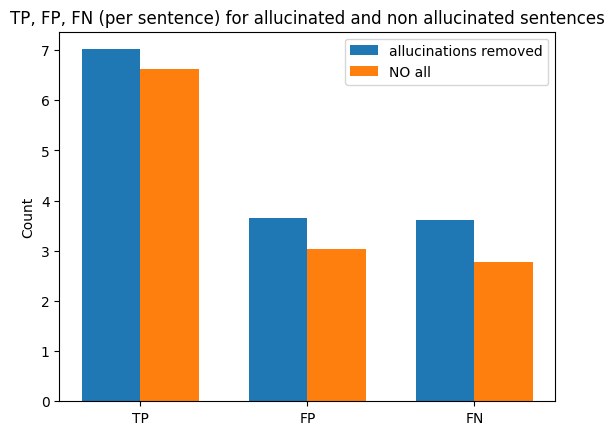

In [16]:
import matplotlib.pyplot as plt

summary_all_removed = evaluator_marginal_allucinations_removed.evaluation_table['evaluation'].sum() / evaluator_marginal_allucinations_removed.data.num_rows
summary_NO_all = evaluator_sentences_with_no_allucinations.evaluation_table['evaluation'].sum() / evaluator_sentences_with_no_allucinations.data.num_rows

fig, ax = plt.subplots()
labels = ['TP', 'FP', 'FN']
width = 0.35
x = range(len(labels))
rects1 = ax.bar(x, summary_all_removed, width, label='allucinations removed')
rects2 = ax.bar([i + width for i in x], summary_NO_all, width, label='NO all')
ax.set_ylabel('Count')
ax.set_title('TP, FP, FN (per sentence) for allucinated and non allucinated sentences')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()

##### Vediamo cosa succede se tolgo dalle entità estratte quelle allucinate, e valuto le performances come se il modello quelle non le avesse estratte

In [48]:
output_analist = OutputAnalist(data_parsed)
data_allucinated_removed_only_heavy = output_analist.remove_allucinations_from_computation(data_parsed, only_heavy=False)
data_allucinated_removed_light = output_analist.remove_allucinations_from_computation(data_parsed, only_heavy=True)


evaluator_light = Evaluator(data=data_allucinated_removed_light, offset=False, output_cleaner=None)
evaluator_light.generate_evaluation_table(similar_is_equal_threshold=100,
                                    words_level=True, 
                                    similarity_types=['case', 'subset', 'superset'],
                                    already_parsed_inputs=True,
                                    add_TP_FP_TN_FN_to_data=True)

evaluator_heavy =  Evaluator(data_allucinated_removed_only_heavy, offset=False, output_cleaner=None)
evaluator_heavy.generate_evaluation_table(similar_is_equal_threshold=100,
                                                                   words_level=True, 
                                                                   similarity_types=['case', 'subset', 'superset'], 
                                                                   already_parsed_inputs=True,
                                                                   add_TP_FP_TN_FN_to_data=True
                                                                   )
print(f"light allucinations removed -> f1:{evaluator_light.evaluation_table['f1']}")
print(f"heavy allucinations removed -> f1:{evaluator_heavy.evaluation_table['f1']} ")
print(f"no allucination removed     -> f1:{ evaluator.evaluation_table['f1']}")

light allucinations removed -> f1:0.6911910009880672
heavy allucinations removed -> f1:0.6885841981668055 
no allucination removed     -> f1:0.6870527980718536


##### guardiamo quante volte è successo che entità duplicate (perfect match) sono state estratte:

In [54]:
res = output_analist.count_repetitions_in_extraction()
print(f"n_duplicated_ent: {res['n_duplicated_ent']}, n_extracted_ent: {res['n_extracted_ent']}, n_extracted_deduplicated_ent: {res['n_extracted_deduplicated_ent']}\n the percentage of duplicated entities over the total of extracted is {round(res['n_duplicated_ent']/res['n_extracted_ent']*100,1)}%\n the percentage of duplicated entities over the total of valid entities is {round(res['n_extracted_deduplicated_ent']/res['n_extracted_ent']*100,1)}%")

n_duplicated_ent: 2536, n_extracted_ent: 7125, n_extracted_deduplicated_ent: 4589
 the percentage of duplicated entities over the total of extracted is 35.6%
 the percentage of duplicated entities over the total of valid entities is 64.4%


## JOINT ANALYSIS with seq2seq

In [88]:
from datasets import load_dataset
checkpoint = "ferrazzipietro/bestResults_LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_16_32_0.05_2_0.0002_3EpochsLast_eval"
data_seq2seq = load_dataset(checkpoint, split="test")

Generating test split: 100%|██████████| 681/681 [00:00<00:00, 63478.03 examples/s]


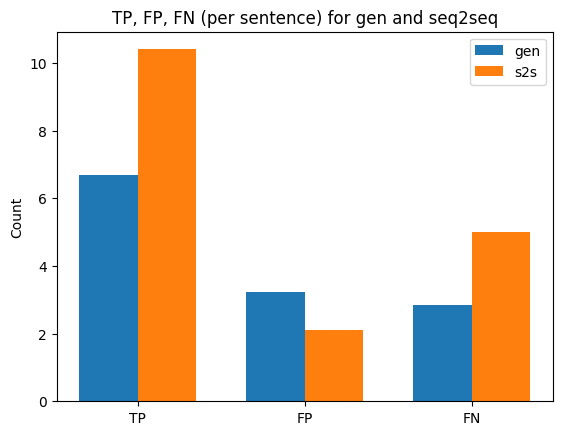

In [90]:
import matplotlib.pyplot as plt

summary_gen = output_analist.data.to_pandas()[['TP', 'FP', 'FN']].sum() / output_analist.data.num_rows
summary_seq2seq = data_seq2seq.to_pandas()[['TP', 'FP', 'FN']].sum() / data_seq2seq.num_rows

fig, ax = plt.subplots()
labels = ['TP', 'FP', 'FN']
width = 0.35
x = range(len(labels))
rects1 = ax.bar(x, summary_gen, width, label='gen')
rects2 = ax.bar([i + width for i in x], summary_seq2seq, width, label='s2s')
ax.set_ylabel('Count')
ax.set_title('TP, FP, FN (per sentence) for gen and seq2seq')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()

In [ ]:
- togliere le allucinazioni fa fare le performance dell'altro s2s? Se sì, allora le allucinazioni sono IL problema, altrimenti è il modello
- grafico lunghezza in token delle entità estratte e relativo f1
- rapport tra allucinazioni e FP. 
- le allucinazioni da dove vengono fuori? Sono sinonimi, acronomi di entità vere? le all. sono risolvibili o no?
- capita che si siano allcuniazioni intra parola (es. "covid-20" invece di "covid-19")?

- test significatività f1 vs f1